In [2]:
import mne
import matplotlib.pyplot as plt

filePath = r"/srv/eeg_reconstruction/shared/emotiv-dataset/raw/subj01/session_2/block_1/Subject 1, Session 2, Block 1 Recording_FLEX2_213075_2024.06.14T18.16.26.07.00.md.edf"
filePath = filePath.replace("\\","/")
raw = mne.io.read_raw_edf(filePath, preload=True)

Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/raw/subj01/session_2/block_1/Subject 1, Session 2, Block 1 Recording_FLEX2_213075_2024.06.14T18.16.26.07.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 55807  =      0.000 ...   217.996 secs...


In [3]:
raw.info

Measurement date,"June 14, 2024 18:16:26 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,127 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


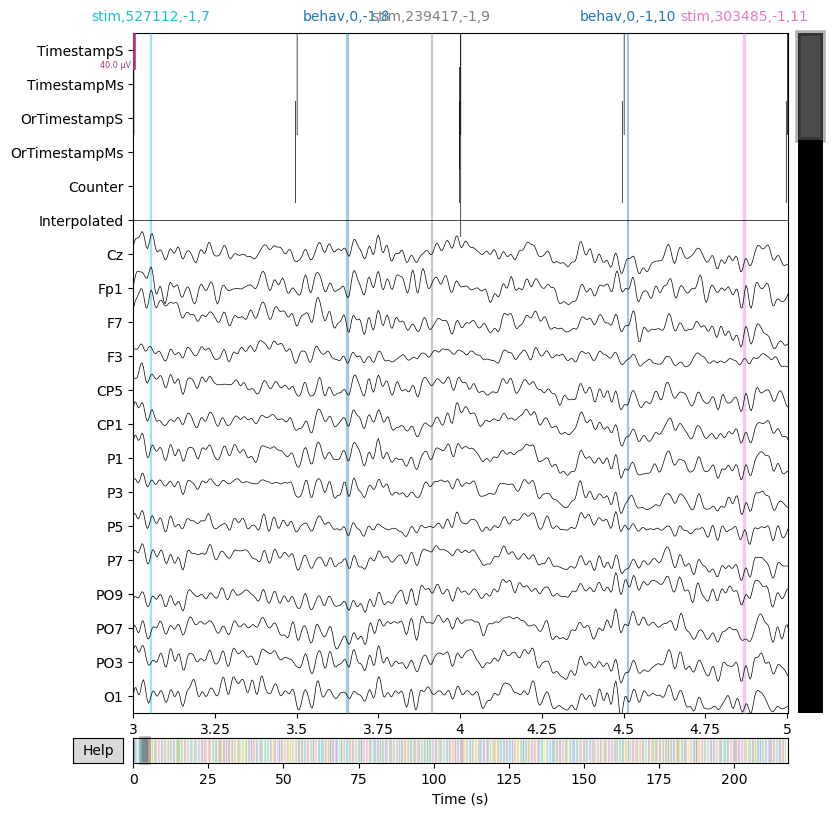

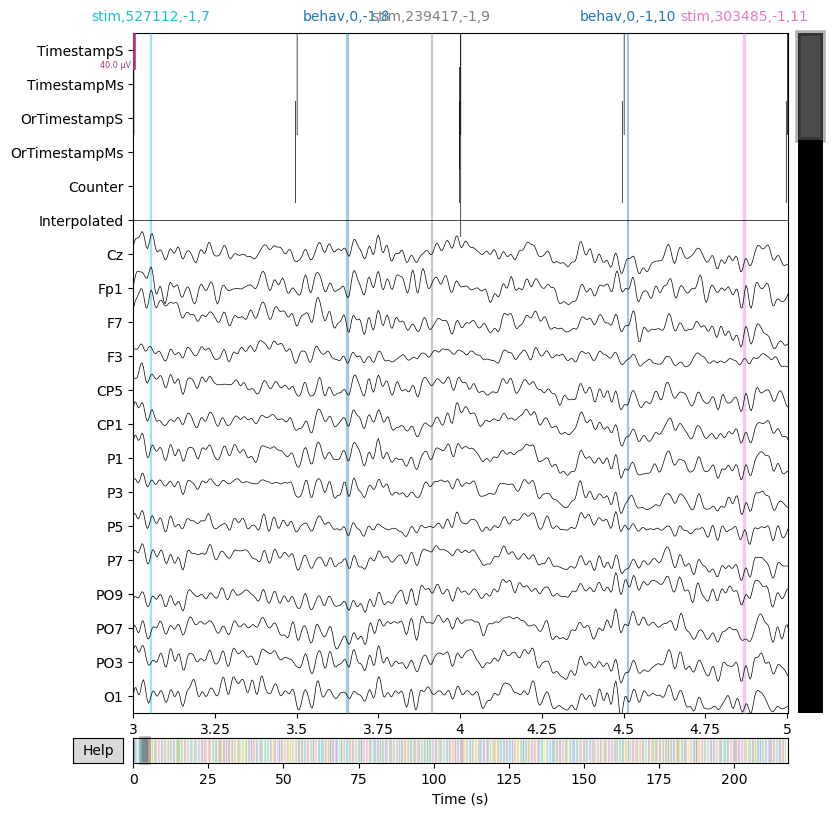

In [6]:
raw.plot(start=3, duration=2)

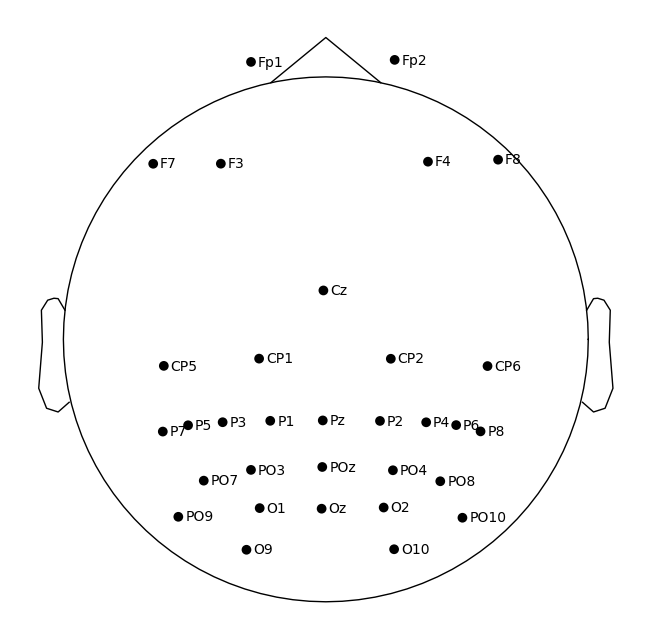

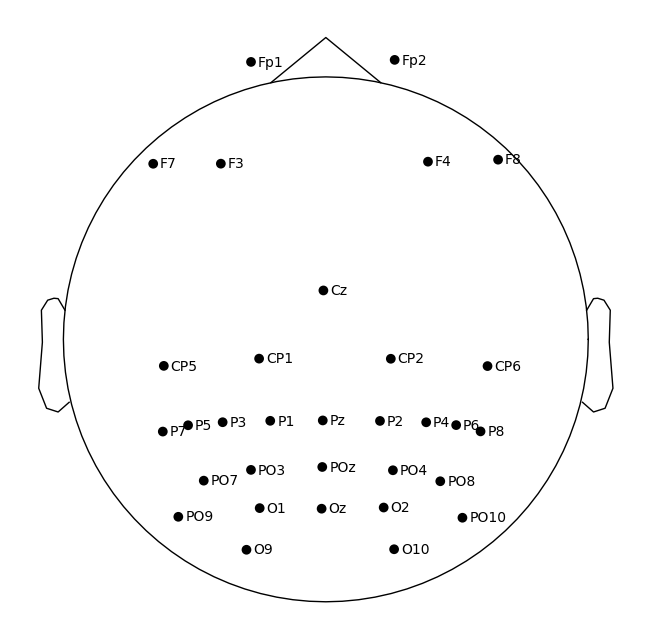

In [12]:
montage = mne.channels.make_standard_montage('standard_1020')

eeg_channels = ['Cz',
 'Fp1',
 'F7',
 'F3',
 'CP5',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'PO9',
 'PO7',
 'PO3',
 'O1',
 'O9',
 'Pz',
 'POz',
 'Oz',
 'O10',
 'O2',
 'PO4',
 'PO8',
 'PO10',
 'P8',
 'P6',
 'P4',
 'P2',
 'CP2',
 'CP6',
 'F4',
 'F8',
 'Fp2']

# Restrict data to only these EEG channels using the new recommended method
raw.pick(eeg_channels)

raw.set_montage(montage)

# Plot the electrodes
raw.plot_sensors(kind='topomap', show_names=True)

In [13]:
# Load events from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)

# Create dictionaries for stimulus and behavior event IDs
stim_event_ids = {key: value for key, value in event_id.items() if key.startswith('stim')}
behav_event_ids = {key: value for key, value in event_id.items() if key.startswith('behav')}
code_to_desc = {v: k for k, v in event_id.items()}

# Since stim and behav codes increment sequentially, assume events are paired in order
dataset = []
sfreq = 128
sample_time_ms = 1000/sfreq
for i in range(len(events) - 1):  # Exclude the last event to avoid out-of-range error
    stim_time = events[i, 0]
    stim_id = events[i, 2]
    if stim_id in stim_event_ids.values():
        event_desc = code_to_desc[stim_id]  # Get the descriptive event string
        stim_value = int(event_desc.split(',')[1])  # The second item is the stimulus value

        behav_time = events[i+1, 0] 
        behav_id = events[i+1, 2]
        event_desc = code_to_desc[behav_id]
        behav_value = int(event_desc.split(',')[1])

        # Recall behavioural mapping:
        # 0: is_oddball and not space_pressed (-1 reaction time)
        # 1: not is_oddball and space_pressed
        # 2: is_oddball and space_pressed
        # 3: is_oddball and not space_pressed (-1 reaction time)
        if behav_value == 0 or behav_value == 3:
            reaction_time = None
        elif behav_value == 1 or behav_value == 2:
            reaction_time = (behav_time - stim_time)*sample_time_ms
        
        coco_id = stim_value
        if stim_value == 100000:
            prev_stim_id = events[i-2, 2]
            event_desc = code_to_desc[prev_stim_id]
            coco_id = int(event_desc.split(',')[1])
            stim_time = events[i-2, 0]
        
        record = {
            "time": stim_time*sample_time_ms,
            "coco_id": coco_id,
            "behaviour": behav_value,
            "reaction_time": reaction_time
        }

        # Save record only if record is oddball, or if record isn't oddball but next one is
        next_is_oddball = False
        if i+2 < len(events):
            next_stim_id = events[i+2,2]
            event_desc = code_to_desc[next_stim_id] 
            next_stim_value = int(event_desc.split(',')[1])
            next_is_oddball = (next_stim_value == 100000)

        if stim_value == 100000 or not next_is_oddball:
            dataset.append(record)

# epochs = mne.Epochs(raw, events, event_id=stim_event_ids, tmin=-0.05, tmax=0.60, preload=True)

Used Annotations descriptions: ['behav,0,-1,10', 'behav,0,-1,100', 'behav,0,-1,102', 'behav,0,-1,104', 'behav,0,-1,106', 'behav,0,-1,108', 'behav,0,-1,110', 'behav,0,-1,112', 'behav,0,-1,114', 'behav,0,-1,118', 'behav,0,-1,12', 'behav,0,-1,120', 'behav,0,-1,122', 'behav,0,-1,124', 'behav,0,-1,126', 'behav,0,-1,128', 'behav,0,-1,130', 'behav,0,-1,132', 'behav,0,-1,134', 'behav,0,-1,138', 'behav,0,-1,14', 'behav,0,-1,140', 'behav,0,-1,142', 'behav,0,-1,144', 'behav,0,-1,148', 'behav,0,-1,150', 'behav,0,-1,152', 'behav,0,-1,154', 'behav,0,-1,158', 'behav,0,-1,16', 'behav,0,-1,160', 'behav,0,-1,162', 'behav,0,-1,166', 'behav,0,-1,168', 'behav,0,-1,170', 'behav,0,-1,172', 'behav,0,-1,174', 'behav,0,-1,176', 'behav,0,-1,178', 'behav,0,-1,18', 'behav,0,-1,180', 'behav,0,-1,182', 'behav,0,-1,186', 'behav,0,-1,188', 'behav,0,-1,190', 'behav,0,-1,192', 'behav,0,-1,194', 'behav,0,-1,198', 'behav,0,-1,2', 'behav,0,-1,20', 'behav,0,-1,200', 'behav,0,-1,202', 'behav,0,-1,204', 'behav,0,-1,206', 'beh

In [14]:
dataset

[{'time': 179.6875, 'coco_id': 135592, 'behaviour': 0, 'reaction_time': None},
 {'time': 2164.0625, 'coco_id': 132778, 'behaviour': 0, 'reaction_time': None},
 {'time': 4085.9375, 'coco_id': 555254, 'behaviour': 0, 'reaction_time': None},
 {'time': 6101.5625, 'coco_id': 527112, 'behaviour': 0, 'reaction_time': None},
 {'time': 7820.3125, 'coco_id': 239417, 'behaviour': 0, 'reaction_time': None},
 {'time': 9734.375, 'coco_id': 303485, 'behaviour': 0, 'reaction_time': None},
 {'time': 11398.4375,
  'coco_id': 533979,
  'behaviour': 0,
  'reaction_time': None},
 {'time': 13507.8125,
  'coco_id': 574739,
  'behaviour': 0,
  'reaction_time': None},
 {'time': 15351.5625,
  'coco_id': 452183,
  'behaviour': 0,
  'reaction_time': None},
 {'time': 17179.6875,
  'coco_id': 372308,
  'behaviour': 0,
  'reaction_time': None},
 {'time': 19257.8125,
  'coco_id': 354639,
  'behaviour': 0,
  'reaction_time': None},
 {'time': 21210.9375,
  'coco_id': 379962,
  'behaviour': 0,
  'reaction_time': None},


# TODO: For Mit.

0. Read our first paper and learn what oddballs are

1. Set the events of the raw eeg to the cleaned ones we just made here. Example to override events:

raw.add_events(events_array, stim_channel='Status', replace=True)
https://github.com/Alljoined/alljoined_preprocessing/blob/main/parse-bdf-event-codes-to-fif.ipynb

So basically we just need to remove all the behav triggers, and also remove the eeg related to the oddballs (by removing the stim trigger for the start of the oddball)

2. Segement the raw eeg into events, like we do in https://github.com/Alljoined/alljoined_preprocessing/blob/5ca87e8eb328715f31ba8e342d911245bf764a8b/eeg2/preprocessing_utils.py#L50C11-L50C32

Basically, just copy the script for alljoined_preprocessing/eeg2/preprocessing.py and adapt it for this dataset.
The output should be a format similar to the input you expect when working with EEG2.

Ie (image conditions, repetitions, channels, timesteps)

